# Nutri-score predictive model for food and beverages

### Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Reading the nutriscore's file

In [2]:
df = pd.read_csv('/Users/dansandler/Proyecto_final_ironhack/final project/filtered_file.csv', sep=',', encoding='utf-8')
df

,nutriscore,product,country,primary_category,secondary_category,ecoscore,energy_kcal_100g,fat_100g,saturated_fat_100g,unsaturated_fat_100g,...,trans_fat_100g,cholesterol_100g,carbs_100g,sugars_100g,fiber_100g,protein_100g,salt_100g,sodium_100g,fruits_veg_nuts_estimate_100g,expected_min_calories
0,a,Skyr,France,Milk and dairy products,Dairy desserts,b,57.0,0.2,0.1,0.0,...,0.0,0.0,3.9,3.9,0.0,10.0,0.09,0.036,0.0,55.45
1,d,Pur jus de pomme,France,Beverages,Fruit juices,c,63.0,0.0,0.0,0.0,...,0.0,0.0,15.5,15.5,0.0,0.2,0.00,0.000,0.0,55.05
2,a,Salade de carottes râpées,France,Composite foods,One-dish meals,b,32.0,0.3,0.1,0.0,...,0.0,0.0,5.3,3.9,0.0,0.9,0.42,0.168,0.0,24.85
3,d,Tarte noix de coco,France,Composite foods,Pizza pies and quiches,unknown,381.0,22.0,15.5,0.0,...,0.0,0.0,27.3,21.9,4.4,4.6,0.10,0.040,0.0,311.95
4,a,Compote de poire,France,Fruits and vegetables,Fruits,b,157.0,0.0,0.0,0.0,...,0.0,0.0,36.0,27.0,3.6,0.6,0.00,0.000,0.0,128.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723657,c,Yaourt vanille,France,Milk and dairy products,Milk and yogurt,b,128.0,7.6,5.1,0.0,...,0.0,0.0,12.0,11.0,0.0,2.7,0.09,0.036,0.0,121.20
723658,c,Riz au lait,France,Milk and dairy products,Dairy desserts,c,150.0,6.1,4.3,0.0,...,0.0,0.0,21.0,14.0,0.0,2.9,0.08,0.032,0.0,140.00
723659,b,Riz parfumé,France,Cereals and potatoes,Cereals,e,351.0,0.5,0.0,0.0,...,0.0,0.0,80.0,0.0,0.0,7.0,0.00,0.000,0.0,312.50
723660,a,Skimmed Milk,United Kingdom,Milk and dairy products,Milk and yogurt,unknown,35.0,0.1,0.1,0.0,...,0.0,0.0,5.0,5.0,0.0,3.6,0.12,0.048,0.0,32.80


## Separate the Beverages from the rest of the categories in order to have one model for food products and another one for beverages products.

In [3]:
df_without_beverage = df[df['primary_category'] != 'Beverages']

In [4]:
df_beverage = df[df['primary_category'] == 'Beverages']

In [5]:
df_beverage.shape

(55040, 22)

In [6]:
df_beverage['nutriscore'].value_counts()

nutriscore
e    23499
c    11883
d     9796
b     8252
a     1610
Name: count, dtype: int64

In [7]:
df_beverage.columns

Index(['nutriscore', 'product', 'country', 'primary_category',
       'secondary_category', 'ecoscore', 'energy_kcal_100g', 'fat_100g',
       'saturated_fat_100g', 'unsaturated_fat_100g',
       'mono_unsaturated_fat_100g', 'poly_unsaturated_fat_100g',
       'trans_fat_100g', 'cholesterol_100g', 'carbs_100g', 'sugars_100g',
       'fiber_100g', 'protein_100g', 'salt_100g', 'sodium_100g',
       'fruits_veg_nuts_estimate_100g', 'expected_min_calories'],
      dtype='object')

In [8]:
df_beverage['primary_category'].unique()

array(['Beverages'], dtype=object)

# Nutri-score predictive model for food and beverages

# Correlation and heatmaps

#### Mapping Nutri-Score to numerical values

In [9]:
nutriscore_mapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}
df_beverage['nutriscore_numeric'] = df_beverage['nutriscore'].map(nutriscore_mapping)

/var/folders/p_/v0r6zns15kvc6kdp98q2n1b00000gn/T/ipykernel_28340/434418876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beverage['nutriscore_numeric'] = df_beverage['nutriscore'].map(nutriscore_mapping)


#### Selecting numeric features

In [10]:
numeric_features_b = df_beverage[['energy_kcal_100g', 'fat_100g', 'saturated_fat_100g',
                       'unsaturated_fat_100g', 'mono_unsaturated_fat_100g',
                       'poly_unsaturated_fat_100g', 'trans_fat_100g',
                       'cholesterol_100g', 'carbs_100g', 'sugars_100g',
                       'fiber_100g', 'protein_100g', 'salt_100g',
                       'sodium_100g', 'fruits_veg_nuts_estimate_100g']]

#### Adding the numeric Nutri-Score to the numeric features

In [11]:
numeric_features_b['nutriscore'] = df_beverage['nutriscore_numeric']

/var/folders/p_/v0r6zns15kvc6kdp98q2n1b00000gn/T/ipykernel_28340/2346446000.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_features_b['nutriscore'] = df_beverage['nutriscore_numeric']


#### Calculating the correlation matrix

In [12]:
correlation_matrix_b = numeric_features_b.corr()

#### Displaying the correlation matrix

In [13]:
correlation_matrix_b

,energy_kcal_100g,fat_100g,saturated_fat_100g,unsaturated_fat_100g,mono_unsaturated_fat_100g,poly_unsaturated_fat_100g,trans_fat_100g,cholesterol_100g,carbs_100g,sugars_100g,fiber_100g,protein_100g,salt_100g,sodium_100g,fruits_veg_nuts_estimate_100g,nutriscore
energy_kcal_100g,1.000000,0.644900,0.525088,0.001230,0.237707,0.084543,0.030164,0.009149,0.800253,0.628902,0.270774,0.417377,0.212216,0.212216,-0.042692,0.215907
fat_100g,0.644900,1.000000,0.877679,0.001446,0.314206,0.105452,0.022767,0.003601,0.210906,0.081099,0.146923,0.177463,0.153115,0.153114,-0.029588,-0.013060
saturated_fat_100g,0.525088,0.877679,1.000000,0.001171,0.167372,0.017889,0.014039,0.003041,0.146614,0.052232,0.066996,0.107335,0.086794,0.086792,-0.001468,0.038858
unsaturated_fat_100g,0.001230,0.001446,0.001171,1.000000,-0.000331,-0.000271,-0.000049,0.000121,0.000962,0.000151,-0.000761,0.000844,0.001033,0.001038,-0.002543,0.004130
mono_unsaturated_fat_100g,0.237707,0.314206,0.167372,-0.000331,1.000000,0.295994,0.001911,0.000304,0.131914,0.089546,0.049367,0.026759,0.085314,0.085313,-0.018215,-0.004506
poly_unsaturated_fat_100g,0.084543,0.105452,0.017889,-0.000271,0.295994,1.000000,0.028604,0.000014,0.019950,-0.009589,0.124762,0.094117,0.029450,0.029444,-0.017000,-0.050489
trans_fat_100g,0.030164,0.022767,0.014039,-0.000049,0.001911,0.028604,1.000000,0.001377,0.029970,0.020457,0.002734,0.007516,0.002208,0.002205,-0.005475,0.000832
cholesterol_100g,0.009149,0.003601,0.003041,0.000121,0.000304,0.000014,0.001377,1.000000,0.002364,0.001944,0.001568,0.023457,0.002896,0.002895,0.007075,0.001247
carbs_100g,0.800253,0.210906,0.146614,0.000962,0.131914,0.019950,0.029970,0.002364,1.000000,0.888987,0.137565,0.102532,0.107388,0.107389,-0.011292,0.313717
sugars_100g,0.628902,0.081099,0.052232,0.000151,0.089546,-0.009589,0.020457,0.001944,0.888987,1.000000,0.027972,0.020337,0.054963,0.054962,0.008195,0.364741


#### Heatmap

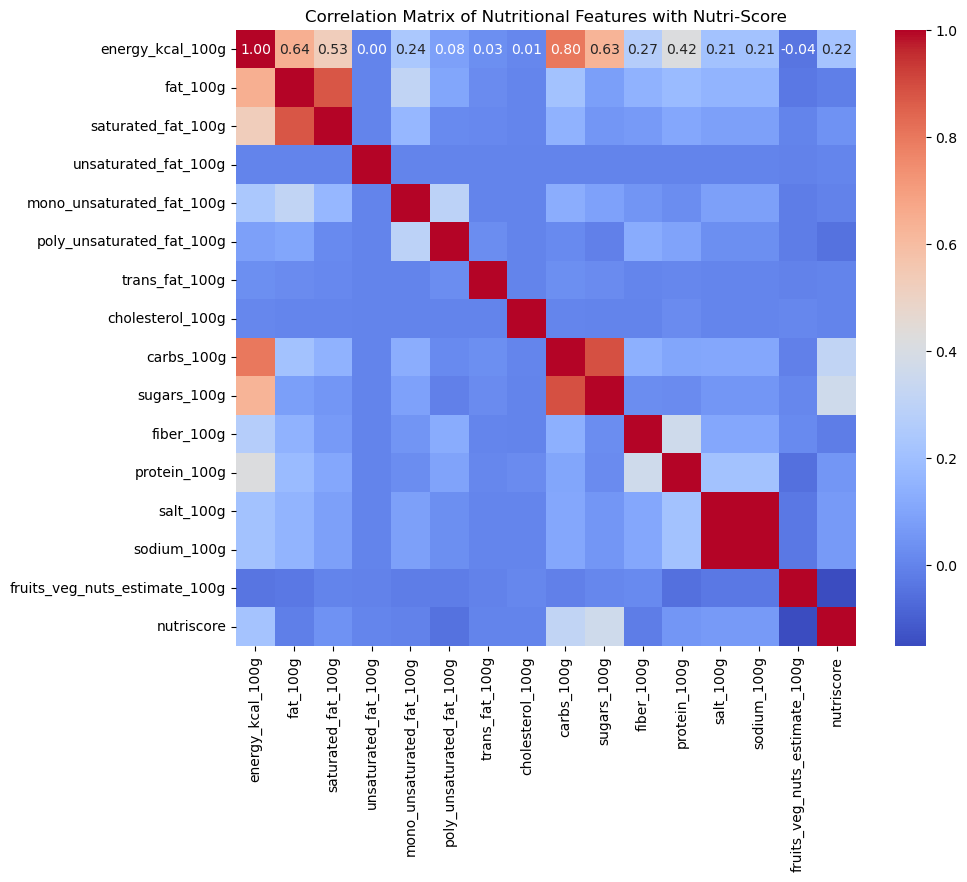

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_b, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Nutritional Features with Nutri-Score')
plt.show()

In [15]:
numeric_features = df_beverage[['energy_kcal_100g', 'fat_100g', 'saturated_fat_100g', 'carbs_100g', 'sugars_100g', 'protein_100g', 'fruits_veg_nuts_estimate_100g', 'salt_100g', 'fiber_100g']]

# Predictive models

### KNN model

In [16]:
X= numeric_features
y = df_beverage["nutriscore"]

#### Convert categorical target variable to numerical values

In [17]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#### Splitting the data into training and test sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

#### Normalizing the data

In [19]:
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

#### Initialize the model


In [20]:
knn = KNeighborsClassifier(n_neighbors=3)

#### Train the model

In [21]:
knn.fit(X_train_norm, y_train)

KNeighborsClassifier(n_neighbors=3)

#### Predicting on the test set

In [22]:
y_pred_knn = knn.predict(X_test_norm)

#### Evaluate KNN

In [23]:
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))
print("KNN Accuracy Score:", accuracy_score(y_test, y_pred_knn))

KNN Classification Report:
              precision    recall  f1-score   support

           a       0.69      0.80      0.74       328
           b       0.87      0.86      0.86      1631
           c       0.87      0.86      0.87      2475
           d       0.88      0.86      0.87      1962
           e       0.91      0.92      0.92      4612

    accuracy                           0.88     11008
   macro avg       0.85      0.86      0.85     11008
weighted avg       0.88      0.88      0.88     11008

KNN Accuracy Score: 0.8840843023255814


### Random Forest Classifier

In [24]:
rf = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')
rf.fit(X_train_norm, y_train)
y_pred_rf = rf.predict(X_test_norm)

#### Evaluate Random Forest

In [25]:
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print("Random Forest Accuracy Score:", accuracy_score(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           a       0.87      0.84      0.86       328
           b       0.92      0.92      0.92      1631
           c       0.91      0.90      0.90      2475
           d       0.92      0.90      0.91      1962
           e       0.93      0.94      0.93      4612

    accuracy                           0.92     11008
   macro avg       0.91      0.90      0.91     11008
weighted avg       0.92      0.92      0.92     11008

Random Forest Accuracy Score: 0.9190588662790697


#### Random Forest Feature Importance:

In [26]:
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)


                         Feature  Importance
4                    sugars_100g    0.203897
5                   protein_100g    0.142596
0               energy_kcal_100g    0.138239
6  fruits_veg_nuts_estimate_100g    0.134346
3                     carbs_100g    0.130365
1                       fat_100g    0.092222
2             saturated_fat_100g    0.060547
7                      salt_100g    0.049455
8                     fiber_100g    0.048332


In [27]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X_train_norm, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())


Cross-validation scores: [0.91018508 0.91166118 0.91085623 0.91358165 0.91607995]
Average cross-validation score: 0.9124728174822018


## Reading the unknown dataframe

In [28]:
df_unknown = pd.read_csv('/Users/dansandler/Proyecto_final_ironhack/final project/unknown_score_file.csv', sep=',', encoding='utf-8')

### Separating the bevarages from the entire 'unknown' dataframe.

In [29]:
df_unknown_bevarage = df_unknown[df_unknown['primary_category'] == 'Beverages']

### Implementing the bevarage nutriscore model to the bevarage products.

In [30]:
X_unknown_bevarage = df_unknown_bevarage[['energy_kcal_100g', 'fat_100g', 'saturated_fat_100g', 'carbs_100g', 'sugars_100g', 'protein_100g', 'fruits_veg_nuts_estimate_100g', 'salt_100g', 'fiber_100g']]
X_unknown_bevarage_scaled = scaler.transform(X_unknown_bevarage)

In [31]:
y_pred_unknown_bevarage = rf.predict(X_unknown_bevarage_scaled)
df_unknown_bevarage['nutriscore'] = y_pred_unknown_bevarage

/var/folders/p_/v0r6zns15kvc6kdp98q2n1b00000gn/T/ipykernel_28340/686088505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unknown_bevarage['nutriscore'] = y_pred_unknown_bevarage


In [32]:
df_unknown_bevarage

,nutriscore,product,country,primary_category,secondary_category,ecoscore,energy_kcal_100g,fat_100g,saturated_fat_100g,unsaturated_fat_100g,...,trans_fat_100g,cholesterol_100g,carbs_100g,sugars_100g,fiber_100g,protein_100g,salt_100g,sodium_100g,fruits_veg_nuts_estimate_100g,expected_min_calories
1,c,Jus de Pomme,France,Beverages,Fruit juices,c,42.0,0.0,0.0,0.0,...,0.0,0.000,9.95,9.67,0.0,0.0,0.00,0.000,0.000000,34.825
20,e,Drink mix,United States,Beverages,Sweetened beverages,unknown,385.0,0.0,0.0,0.0,...,0.0,0.819,96.15,92.31,0.0,0.0,0.00,0.000,0.000000,336.525
30,e,mokate cappuccino vanilla,Ireland,Beverages,Teas and herbal teas and coffees,e,441.0,13.0,12.0,0.0,...,0.0,0.000,74.00,52.00,0.0,6.6,0.30,0.120,0.000000,402.400
49,c,V8 Low Sodium Vegetable Cocktail,Canada,Beverages,Unsweetened beverages,unknown,20.0,0.0,0.0,0.0,...,0.0,0.000,4.40,3.20,0.8,0.8,0.00,0.000,48.148148,18.600
50,d,Coca Cola,Panama,Beverages,Sweetened beverages,not-applicable,28.0,0.0,0.0,0.0,...,0.0,0.000,7.20,7.20,0.0,0.0,0.00,0.000,0.000000,25.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52013,e,Jus d´orange,Belgium,Beverages,Fruit juices,c,42.0,0.5,0.1,0.0,...,0.0,0.000,10.00,10.00,0.0,0.5,0.00,0.000,0.000000,41.500
52024,d,ดับเบิ้ลซี,Thailand,Beverages,Waters and flavored waters,not-applicable,21.9,0.0,0.0,0.0,...,0.0,0.000,5.62,4.38,0.0,0.0,0.00,0.000,0.000000,19.670
52032,d,Energy Gym,Japan,Beverages,Sweetened beverages,not-applicable,41.0,0.0,0.0,0.0,...,0.0,0.000,10.30,0.00,0.0,0.0,0.02,0.008,0.000000,36.050
52044,e,fuze tea pesca e rosa,Italy,Beverages,Teas and herbal teas and coffees,c,33.0,0.0,0.0,0.0,...,0.0,0.000,8.00,8.00,0.0,0.0,0.00,0.000,0.000000,28.000


### Add a boolean column indicating that the nutriscore was predicted or not for beverage DataFrames

In [33]:
df_unknown_bevarage['predicted'] = True
df_beverage['predicted'] = False

/var/folders/p_/v0r6zns15kvc6kdp98q2n1b00000gn/T/ipykernel_28340/4095205824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unknown_bevarage['predicted'] = True
/var/folders/p_/v0r6zns15kvc6kdp98q2n1b00000gn/T/ipykernel_28340/4095205824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_beverage['predicted'] = False


### Concatenating the Beverages DataFrame with Known Nutriscore and the Beverages DataFrame with Predicted Nutriscore

In [34]:
df_beverage_after_pred = pd.concat([df_beverage, df_unknown_bevarage,], ignore_index=True)

### Extracting the file as csv file.

In [35]:
df_beverage_after_pred.to_csv('/Users/dansandler/Proyecto_final_ironhack/final project/df_beverage_after_pred.csv', index=False)